# Project PML

The datasets provided include the players data for the Career Mode from FIFA 20 ("players_20.csv").

### First part

We will explore a little bit the data set to check for null values and we will do some check on how the data looks.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools 
import seaborn as sns
import math

In [2]:
data = pd.read_csv('players_20.csv')

data.drop(['sofifa_id','player_url','real_face','nation_position','nation_jersey_number',],axis=1,inplace=True)

Let's compare different attributes of players based on their roles.


In [3]:
#print(data.loc[data['player_positions'] == 'GK'])


gk_players = data.loc[data['player_positions'] == 'GK']

# "RW", "LW"
wing_players_RW = data.loc[data['player_positions'] == 'RW']   
wing_players_LW = data.loc[data['player_positions'] == 'LW']

wing_players = pd.concat([wing_players_LW, wing_players_RW]).drop_duplicates().reset_index(drop=True)

#"CM" "LM" "RM"

midfielder_players_CM = data.loc[data['player_positions'] == 'CM']
midfielder_players_LM = data.loc[data['player_positions'] == 'LM']
midfielder_players_RM = data.loc[data['player_positions'] == 'RM']

midfielder_players = pd.concat([midfielder_players_CM, midfielder_players_LM, midfielder_players_RM]).drop_duplicates().reset_index(drop=True)

#"CB", "RB", "LB"

cb_players_CB = data.loc[data['player_positions'] == 'CB']
cb_players_RB = data.loc[data['player_positions'] == 'LM']
cb_players_LB = data.loc[data['player_positions'] == 'RM']

cb_players = pd.concat([cb_players_CB, cb_players_LB, cb_players_RB]).drop_duplicates().reset_index(drop=True)


#"CF", "ST"

st_players_CF = data.loc[data['player_positions'] == 'CF']
st_players_ST = data.loc[data['player_positions'] == 'ST']

st_players = pd.concat([st_players_CF, st_players_ST]).drop_duplicates().reset_index(drop=True)

In [4]:
cb_players["player_tag"] = "Defenders"
wing_players["player_tag"] = "Wingers"
gk_players["player_tag"] = "Goal Keepers"
st_players["player_tag"] = "Strikers"
midfielder_players["player_tag"] = "Midfielders"
players = pd.concat([gk_players, cb_players, midfielder_players, wing_players, st_players], axis=0, join="outer")

F:\Anaconda\envs\pml\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
def compare(data, x, y):
    sns.boxenplot(data[x], data[y])
    plt.xlabel("")
    plt.show()

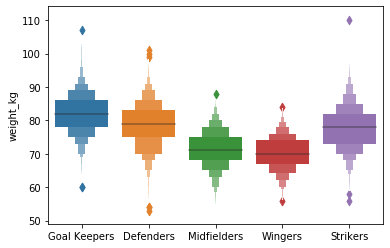

In [6]:
compare(players, "player_tag", "weight_kg")

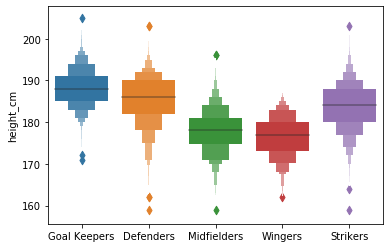

In [7]:
compare(players, "player_tag", "height_cm")

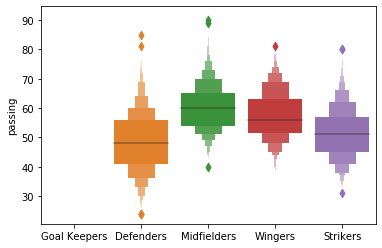

In [8]:
compare(players, "player_tag", "passing")

After those plots its safe to say that the data is relevant, since the attributes are correlated with the players position.

We can observe that midfielders and wingers are in general shorter and weight less than other players since they need to run the whole pitch and create spaces between the lines. Also, they have a higher passing attribute since its one of their main roles in the team.

In [9]:
table_1 = pd.crosstab(players["player_tag"], players["body_type"])

players["body_type"] = players["body_type"].replace(["Courtois"], "Lean")
players["body_type"] = players["body_type"].replace(["Akinfenwa"], "Stocky")

table = pd.crosstab(players["player_tag"], players["body_type"])



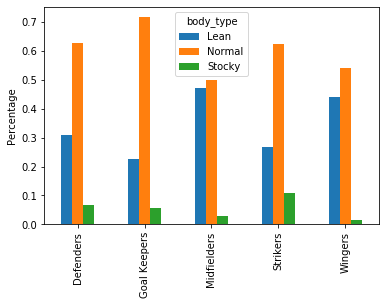

In [10]:
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False)
plt.xlabel('')
plt.ylabel('Percentage')
plt.show()

Here we can see a body type comparison between roles and everything looks pretty much as expected.

# Supervised

So after exploring a bit the data set, i will try to implement Decisional Tree algorithm and K-Nearest Neighbor algorithms for the supervised part to predict players position based on their stats.


## KNN
In k-NN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

## Decisional Tree
Decision tree learning is one of the predictive modelling approaches used in statistics, data mining and machine learning. It uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels.

In [11]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
def matrix(y, y_pred, label):
    res = confusion_matrix(y, y_pred, labels = label)
    row_sums = res.astype(np.float).sum(axis=1)
    res = res/row_sums[:, np.newaxis]
    res = pd.DataFrame(res, columns = label, index = label)
    sns.heatmap(res, annot=True)

We're going to create a column called 'best_pos' in which we'll consider the first role in the player_position to be his best position on field. We'll also going to exclude the goalkeepers since they have their own specific stats.

At first we will try to use 6 of the most common and basic stats for each player to see the results.

In [13]:
data['best_pos'] = data['player_positions'].str.split(',').str[0]
data = data[data['best_pos']!= 'GK'].copy()
data_player = data[data['best_pos']!= 'GK'].copy()

pos = {
    'ST': 'Stricker', 'CF': 'Stricker', 'LW': 'Stricker_wing', 'RW': 'Stricker_wing', 'CM': 'Midfielder',
    'CAM': 'Midfielder', 'CDM': 'Midfielder', 'LM': 'Midfielder_Side', 'RM': 'Midfielder_Side', 'CB': 'Defender',
    'LB': 'Defender_Side', 'RB': 'Defender_Side', 'LWB': 'Defender_Wing', 'RWB': 'Defender_Wing',
}

data_player['best_pos'] = data_player['best_pos'].map(pos)

all_pos = ['Stricker','Stricker_wing','Midfielder','Midfielder_Side','Defender','Defender_Side','Defender_Wing']

Score Decisional Tree:  0.6851338873499538


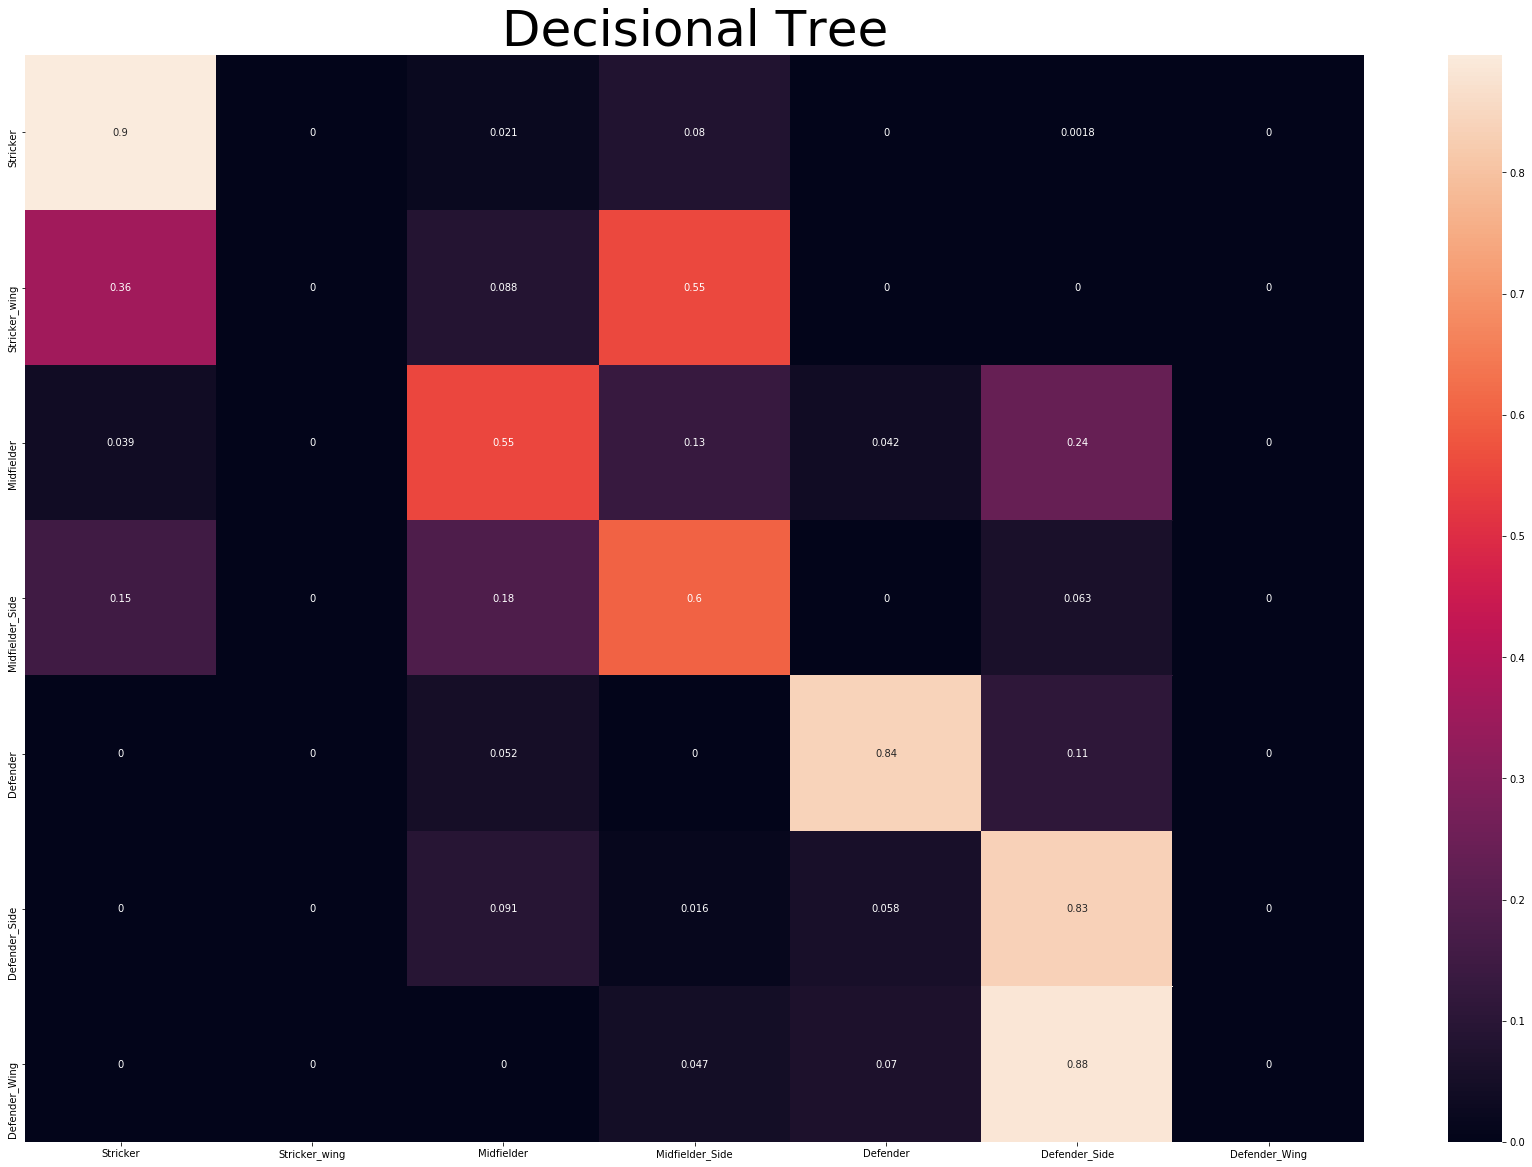

In [14]:
attributes = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

for x in attributes:
    data_player.loc[:, 'n_'+x] = data_player[x] / data_player['overall']

col = ['n_'+x for x in attributes]

X = data_player[col]
y = data_player['best_pos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


#Decision Tree Classifier
fig = plt.subplots(figsize=(30,20))
plt.title('Decisional Tree', fontsize=50)
model = tree.DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)

matrix(y_test, model.predict(X_test), all_pos)
score = model.score(X_test, y_test)

print('Score Decisional Tree: ', score)

So after running the algorithm on 6 stats we can see its already doing a decent job, scoring around 70%.We can see that the algorithm doesnt have major flows like classifying attackers as defenders or major differences between roles.

I tried playing with the depth of the tree, but increasing the depth, the algorithm would just start to associate players with even more roles(probably since there are so few attributes taken in consideration), also the overall accuracy would decrease.

Score KNN:  0.7279162819329025


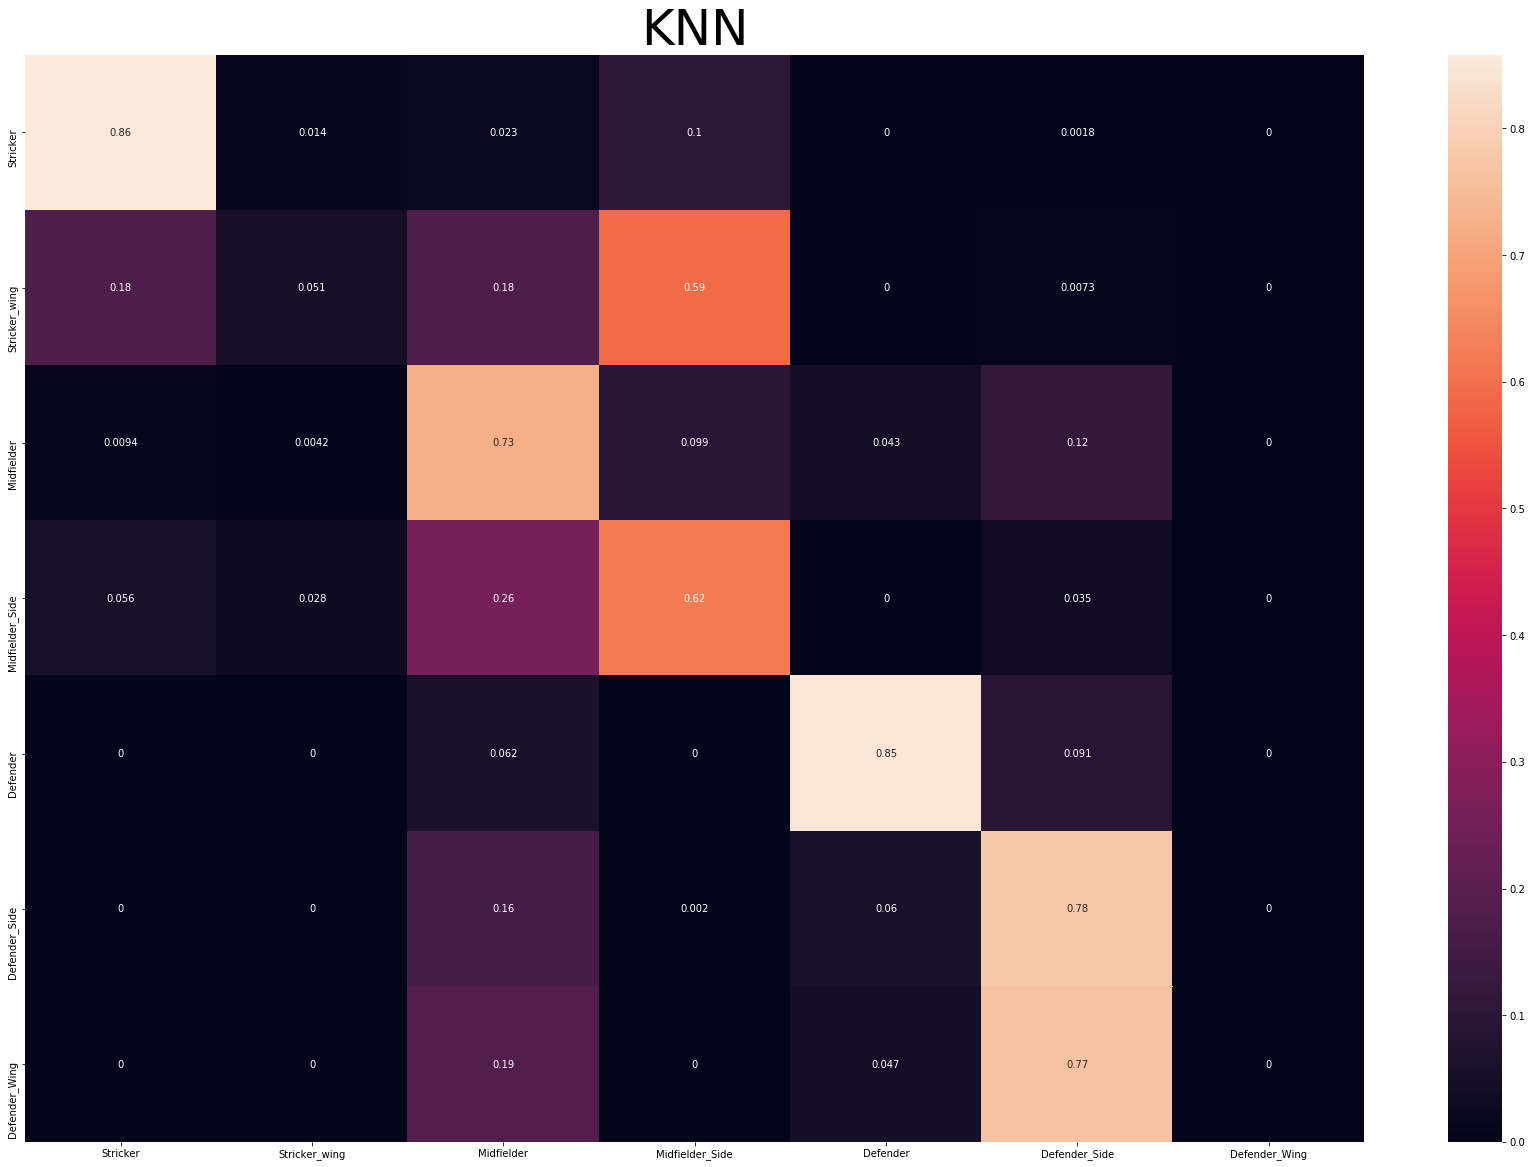

In [15]:
#KNN Classifier
fig = plt.subplots(figsize=(30,20))
plt.title('KNN', fontsize=50)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

matrix(y_test, knn.predict(X_test), all_pos)
score = knn.score(X_test,y_test)
print('Score KNN: ', score)

We can also observe that KNN is doing a little bit better than Decisonal Tree, and from the heat map we can also see that it does a better job classifying players around midfield.

For KNN, increasing K(nr. of neighbors) would not change much the accuracy and aswell as in decisional tree, it would just try to fit type of players into more roles.

It is normal what the heat map shows since the positions in midfield are versatile and players have similar stats around there.


Now we will try the same thing but we will add far more attributes.

In [16]:
attributes = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
        'attacking_crossing','attacking_finishing','attacking_heading_accuracy',
        'attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve',
        'skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration',
        'movement_sprint_speed','movement_agility','movement_reactions','movement_balance',
        'power_shot_power','power_jumping','power_stamina','power_strength','power_long_shots',
        'mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision',
        'mentality_penalties','mentality_composure','defending_marking','defending_standing_tackle',
        'defending_sliding_tackle']

for x in attributes:
    data_player.loc[:, 'n_'+x] = data_player[x] / data_player['overall']

col = ['n_'+x for x in attributes]

X = data_player[col]
y = data_player['best_pos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


Score Decisional Tree:  0.7426900584795322


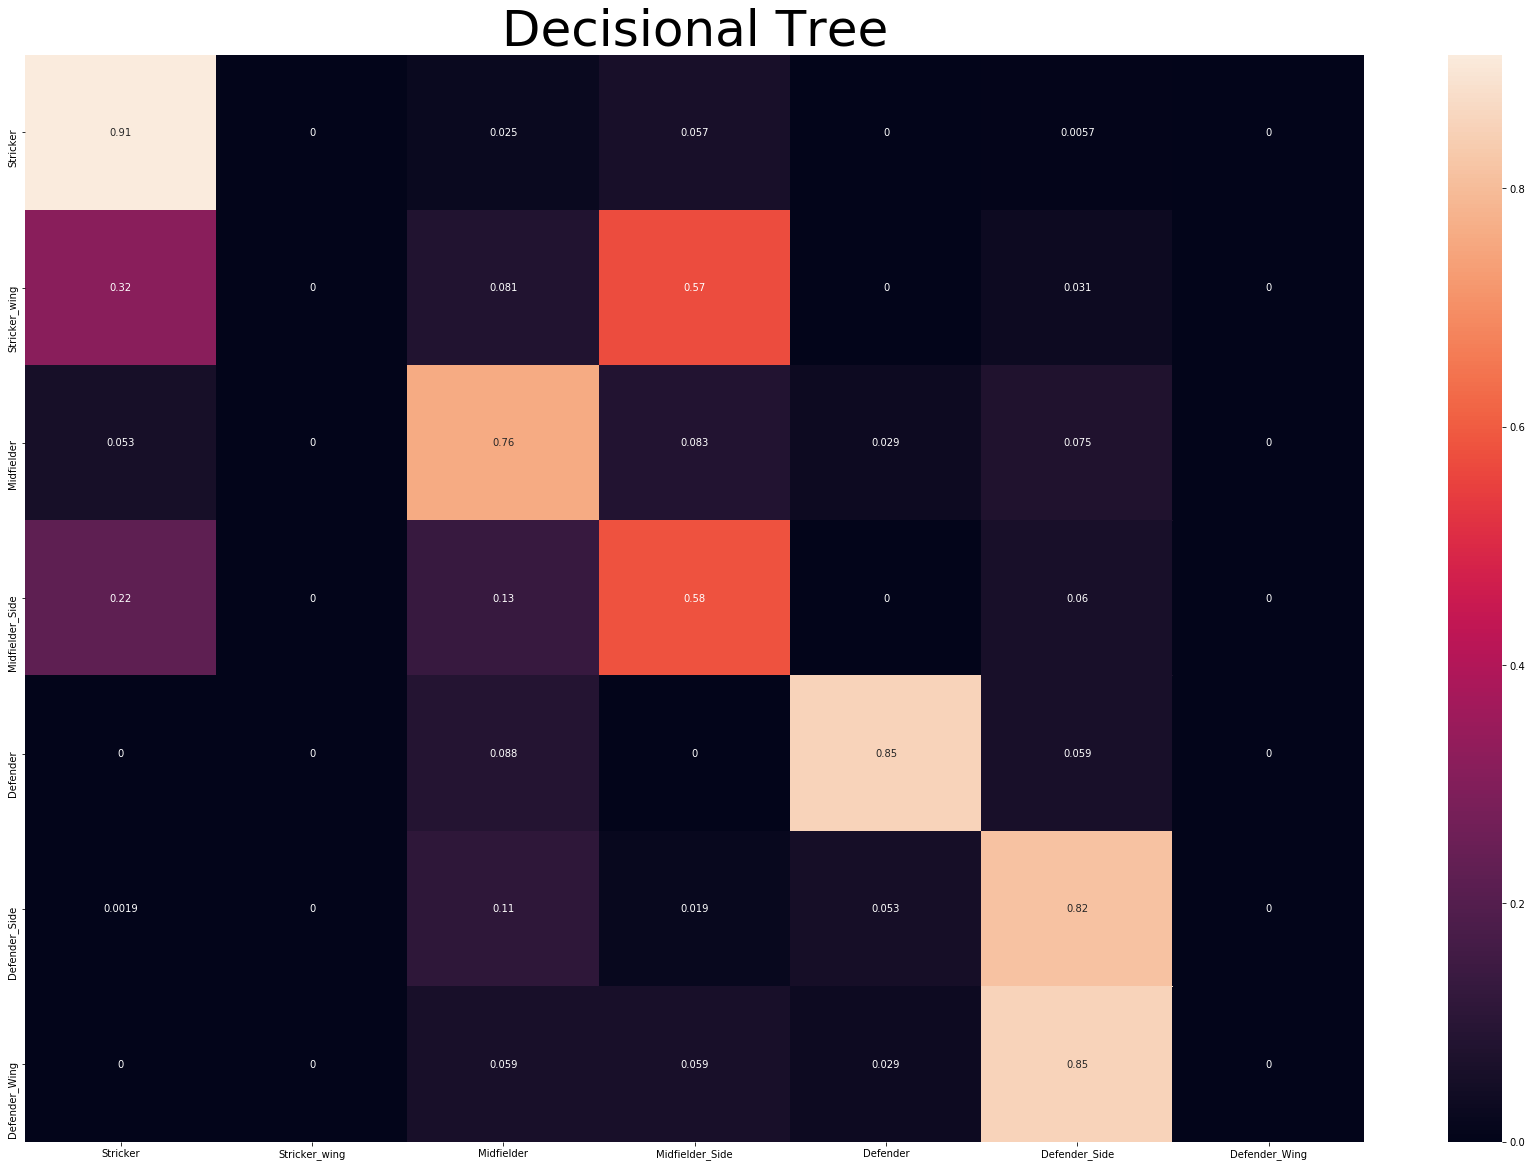

In [17]:
#Decision Tree Classifier
fig = plt.subplots(figsize=(30,20))
plt.title('Decisional Tree', fontsize=50)
model = tree.DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)

matrix(y_test, model.predict(X_test), all_pos)
score = model.score(X_test, y_test)

print('Score Decisional Tree: ', score)


We can opbserve that by adding all the attributes of a player, the classification is much better. Even tough the overall accuracy is not by much greater, the heat map shows more roles fitted better.

Score KNN:  0.7971683594952294


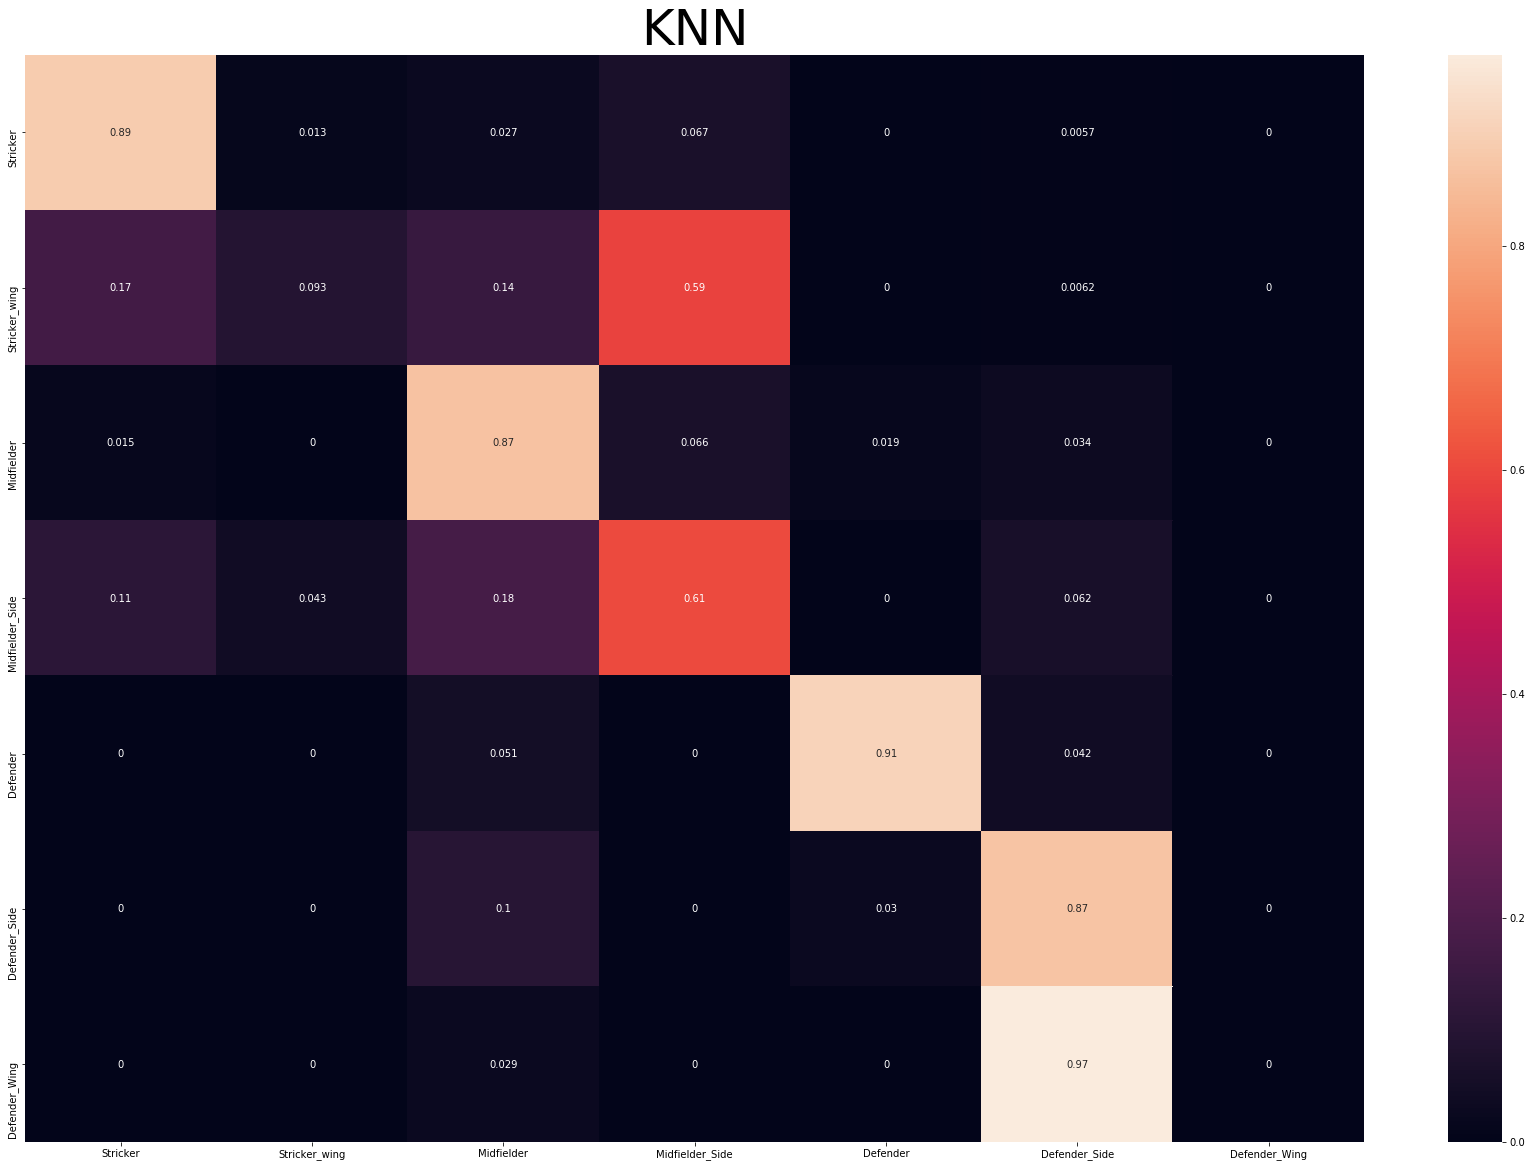

In [18]:
#KNN Classifier
fig = plt.subplots(figsize=(30,20))
plt.title('KNN', fontsize=50)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

matrix(y_test, knn.predict(X_test), all_pos)
score = knn.score(X_test,y_test)
print('Score KNN: ', score)

After this experiment, i will reduce the number of roles into atackers, midfielders and defenders and check again the algorithms.

In [19]:
data['best_pos'] = data['player_positions'].str.split(',').str[0]
data_player = data[data['best_pos']!= 'GK'].copy()

pos = {
    'ST': 'Stricker', 'CF': 'Stricker', 'LW': 'Stricker', 'RW': 'Stricker', 'CM': 'Midfielder',
    'CAM': 'Midfielder', 'CDM': 'Midfielder', 'LM': 'Midfielder', 'RM': 'Midfielder', 'CB': 'Defender',
    'LB': 'Defender', 'RB': 'Defender', 'LWB': 'Defender', 'RWB': 'Defender',
}

data_player['best_pos'] = data_player['best_pos'].map(pos)

all_pos = ['Stricker','Midfielder','Defender']

In [20]:
attributes = ['attacking_crossing','attacking_finishing','attacking_heading_accuracy',
        'attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve',
        'skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration',
        'movement_sprint_speed','movement_agility','movement_reactions','movement_balance',
        'power_shot_power','power_jumping','power_stamina','power_strength','power_long_shots',
        'mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision',
        'mentality_penalties','mentality_composure','defending_marking','defending_standing_tackle',
        'defending_sliding_tackle']

for x in attributes:
    data_player.loc[:, 'n_'+x] = data_player[x] / data_player['overall']

col = ['n_'+x for x in attributes]

X = data_player[col]
y = data_player['best_pos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [47]:
import random
count = 0
for x in y:
    aux = random.choice( ['Stricker', 'Midfielder', 'Defender'] )
    if x == aux:
        count += 1
score = count / len(y) * 100
print("Random chance score: "+str(score)+"%")

Random chance score: 33.31486270163773%


In [39]:
print(data_player['best_pos'])

0          Stricker
1          Stricker
2          Stricker
4          Stricker
5        Midfielder
            ...    
18273      Defender
18274      Defender
18275    Midfielder
18276    Midfielder
18277    Midfielder
Name: best_pos, Length: 16242, dtype: object


Score Decisional Tree:  0.8578024007386889


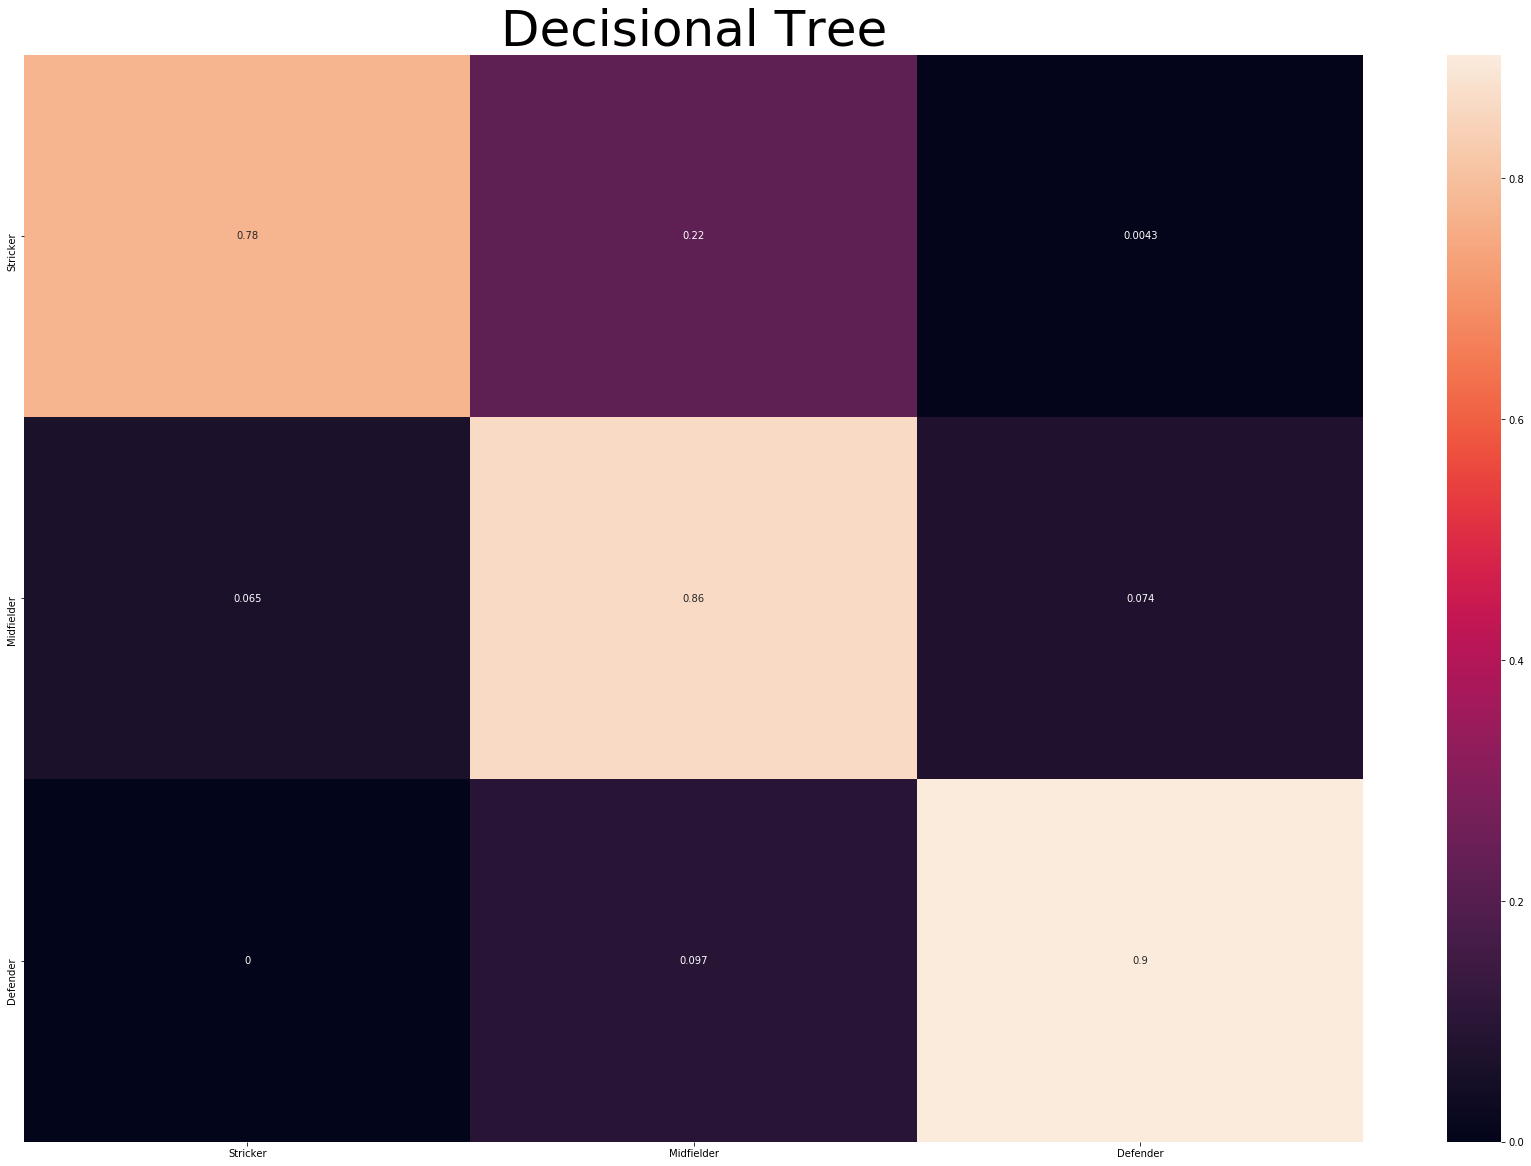

In [21]:
#Decision Tree Classifier
fig = plt.subplots(figsize=(30,20))
plt.title('Decisional Tree', fontsize=50)
model = tree.DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)

matrix(y_test, model.predict(X_test), all_pos)
score = model.score(X_test, y_test)

print('Score Decisional Tree: ', score)


Score KNN:  0.8808864265927978


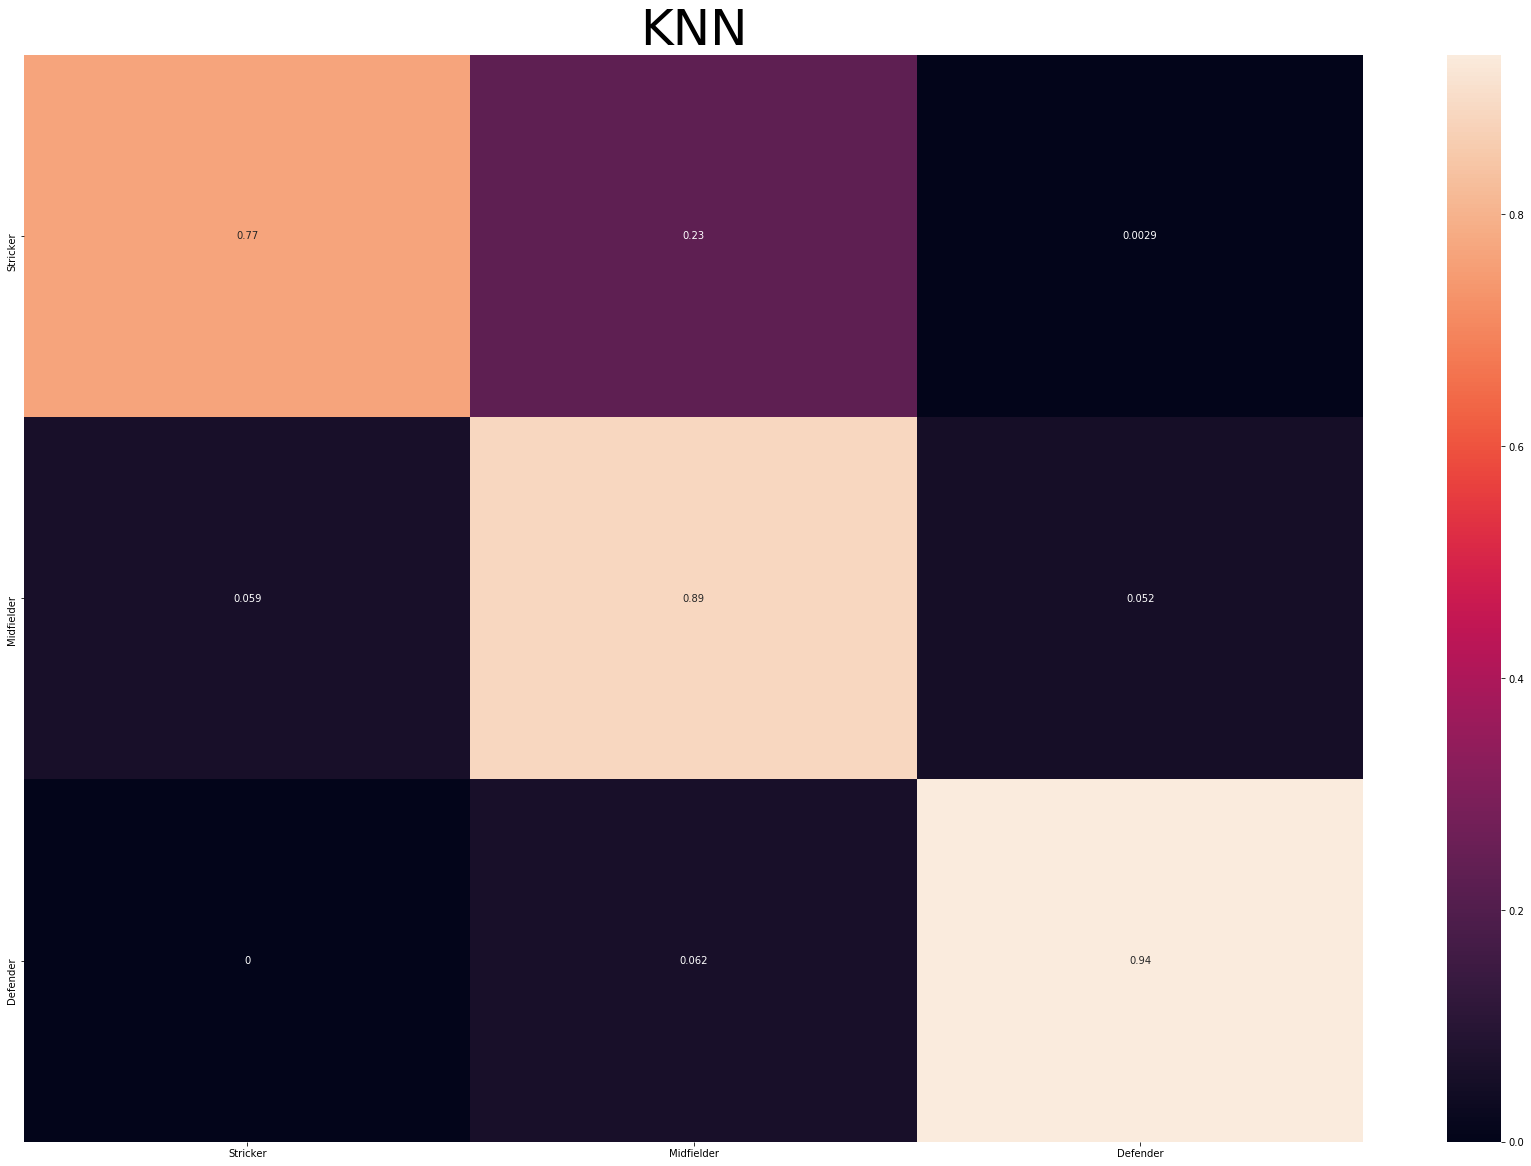

In [22]:
#KNN Classifier
fig = plt.subplots(figsize=(30,20))
plt.title('KNN', fontsize=50)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

matrix(y_test, knn.predict(X_test), all_pos)
score = knn.score(X_test,y_test)
print('Score KNN: ', score)

As expected, we have far more better results. This is because positions like LM, RM, LW, RW, LWB, RWB are very similar and many players can swap between those roles any time. 

### Conclusion

So after all the work, we can tell that is possible to classify players into roles based on their attributes. We saw that KNN worked better in all cases than Decisional Tree and we understood the importance of working with the data and getting the correct information, creating the right number of classes and so on.


# Unsupervised

For the unsupervised part i will try to implement K-Means algorithm and DBSCAN.

### K-Means


Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.


To establish the optimal number of clusters for K-Means i will use the Elbow method. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. But first, we're going to drop columns that are not usefull for clustering.

In [23]:
data_cluster = pd.read_csv('players_20.csv')
data = pd.read_csv('players_20.csv')
data.drop(['sofifa_id','player_url','real_face','nation_position','nation_jersey_number',],axis=1,inplace=True)
data['player_positions'] = data['player_positions'].str.split(',').str[0]
data = data[(data['player_positions'] != 'GK' )]

data_cluster.drop(['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic','sofifa_id','player_url','long_name','loaned_from','gk_diving','gk_handling','gk_kicking','gk_reflexes','gk_speed','gk_positioning',
'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes','ls','st','rs','lw','lf','cf','rf',
'rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb',
'short_name','age','dob','height_cm','weight_kg','nationality','club','potential','value_eur','wage_eur',
'preferred_foot','international_reputation','weak_foot','skill_moves','work_rate','body_type','real_face','release_clause_eur',
'player_tags','team_position','team_jersey_number','joined','contract_valid_until','nation_position','nation_jersey_number','player_traits',
'overall'], 1, inplace=True)
data_cluster['player_positions'] = data_cluster['player_positions'].str.split(',').str[0]
data_cluster = data_cluster[(data_cluster['player_positions'] != 'GK' )]
data_cluster.drop(['player_positions',], 1, inplace=True)
data_cluster.drop(['defending_standing_tackle'], 1, inplace=True)




data_cluster.fillna(0, inplace=True)



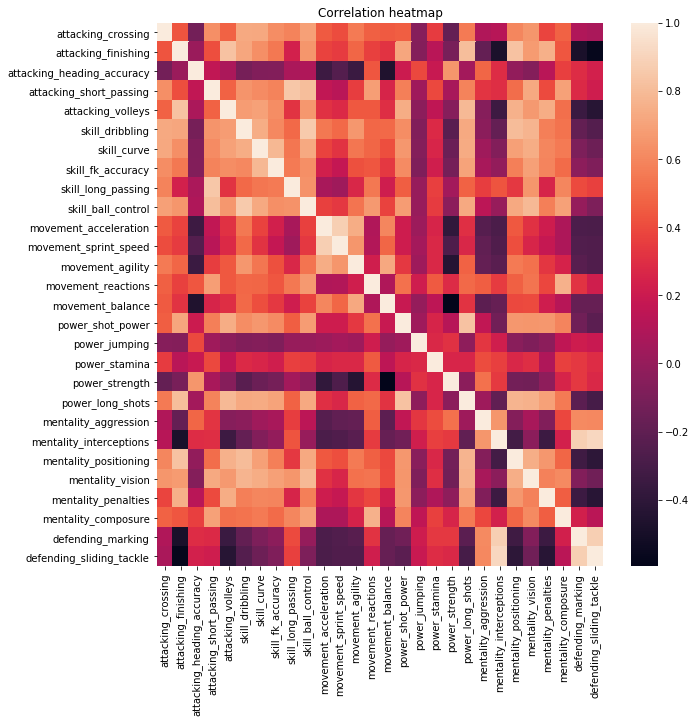

In [24]:
fig, ax = plt.subplots(figsize=(10,10)) 
plt.title('Correlation heatmap')
sns.heatmap(data_cluster.corr())

In [25]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics 
from scipy.spatial.distance import cdist 


distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
X = np.array(data_cluster)
K = range(1,10) 

for k in K: 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

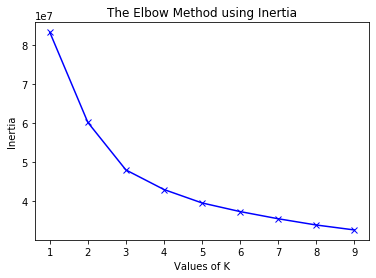

In [26]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

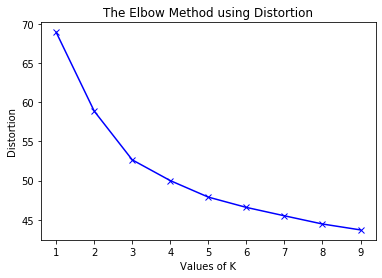

In [27]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.

Inertia: It is the sum of squared distances of samples to their closest cluster center.



After reviewing the plots generated by the elbow method, we can assume that 3 clusters are more than enough since we can classify players as atackers, midfielders and defenders.

In [28]:
clusters_nr = 3
KMeans_cluster = KMeans(n_clusters=clusters_nr, n_init=100, random_state=23)
KMeans_cluster.fit(X)

centroids = KMeans_cluster.cluster_centers_
labels = KMeans_cluster.labels_

# assign a player to his cluster group
data['cluster_group'] = np.nan
for i in range(len(X)):
    data['cluster_group'].iloc[i] = labels[i]



F:\Anaconda\envs\pml\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


<Figure size 1512x2160 with 0 Axes>

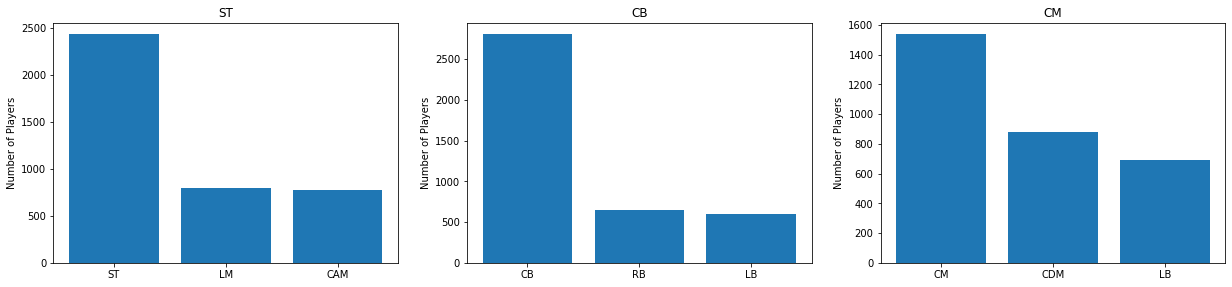

In [29]:
fig = plt.figure(figsize=(21,30))


def cluster_type(cluster_label):
    cluster = data[(data['cluster_group']==cluster_label)]
    v_counts = pd.value_counts(cluster['player_positions'])
    position = v_counts.index[0]
    return position

def plot_clusters(column, nr_columns):
    fig = plt.figure(figsize=(21,60))
    plt.subplots_adjust(hspace = 0.4)
    for group in range(clusters_nr):
        cluster = data[(data['cluster_group']==group)]
        v_counts = pd.value_counts(cluster[column])
        v_counts = v_counts[:nr_columns]
        ax1 = fig.add_subplot(10, 3, group+1)
        ax1.bar(v_counts.index, v_counts.values)
        ax1.set(title=cluster_type(group), ylabel='Number of Players')
        
            
            
plot_clusters('player_positions', 3)

We can see that it did a pretty good job on clustering, every cluster is labeled with the dominant position in it. So we have 3 clusters (CM(Midfield), CB(Defense) and ST(Atack)) and all of them define the 3 postions in football. We can also observe that the CB(Defensive) cluster is the best since the next 2 positions are also defensive ones.

### Agglomerative Clustering


The agglomerative clustering is the most common type of hierarchical clustering used to group objects in clusters based on their similarity. It’s also known as AGNES (Agglomerative Nesting). The algorithm starts by treating each object as a singleton cluster. Next, pairs of clusters are successively merged until all clusters have been merged into one big cluster containing all objects. The result is a tree-based representation of the objects, named dendrogram.

In [30]:
data = pd.read_csv('players_20.csv')
data.drop(['sofifa_id','player_url','real_face','nation_position','nation_jersey_number',],axis=1,inplace=True)
data['player_positions'] = data['player_positions'].str.split(',').str[0]
data = data[(data['player_positions'] != 'GK' )]

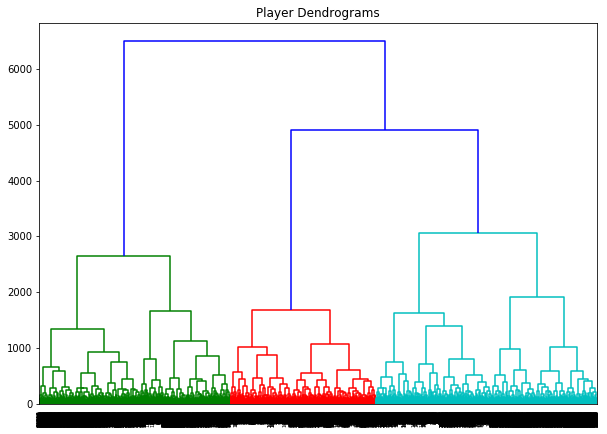

In [34]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Player Dendrograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

On this dendrogram we can see that it probably starts with defense and attack, then it may be splitting into midfielders and after that it tries to split in all roles. What's clear is the three main roles in football

A dendrogram is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering. The main use of a dendrogram is to work out the best way to allocate objects to clusters.

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

labels = cluster.labels_


data['cluster_group'] = np.nan
for i in range(len(X)):
    data['cluster_group'].iloc[i] = labels[i]


F:\Anaconda\envs\pml\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


<Figure size 1512x2160 with 0 Axes>

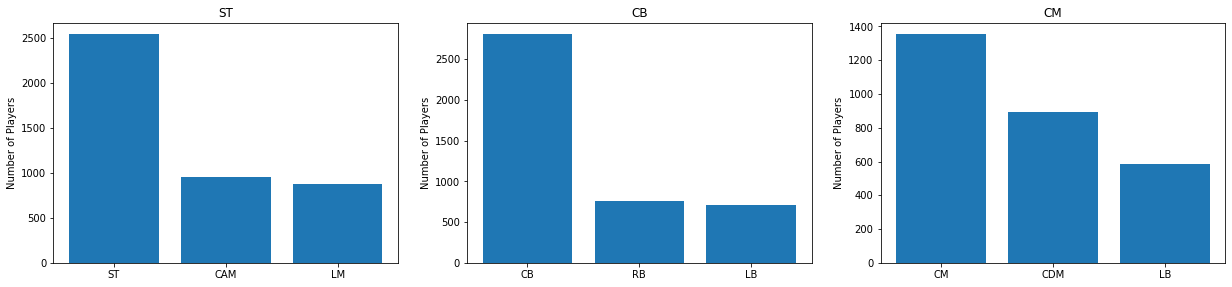

In [33]:
clusters_nr = 3
nrows = 10
ncols = 3

fig = plt.figure(figsize=(21,30))


plot_clusters('player_positions', 3)

We can see that Agglomerative Clustering produces almost the same results as K-Means(there are some small differences in the numbers of each role). Its still good since each cluster is dominated by a Defensive, a Midfield and Striker role.

## Conclusion



So, both the algorithms look for similarities among data and both use the same approaches to decide the number of clusters. Since the data may not be the best cluster-friendly, i think the algorithms achieved what we proposed(to split the players in 3 main roles).